In [132]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn


In [133]:
# data = pd.read_csv("Xtrain.csv", header=None)
data = scipy.io.loadmat('Xtrain.mat')['Xtrain'].flatten()

## Exploratory analysis / Preprocessing

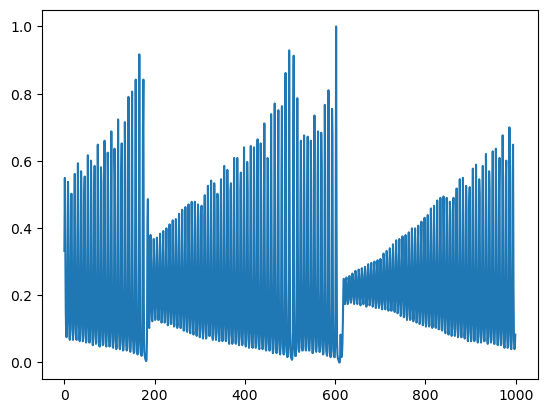

In [134]:
data = data.reshape(-1, 1)
minmax_scaler = MinMaxScaler()
scaled_data = minmax_scaler.fit_transform(data)
plt.plot(scaled_data)

In [135]:
lookback = 20

In [136]:
def generate_xy(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

In [137]:
X,y = generate_xy(scaled_data, lookback)

train_index = int(len(X)*0.8)

X_train = X[:train_index]
X_test = X[train_index:]

y_train = y[:train_index]
y_test = y[train_index:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(784, 20, 1) (196, 20, 1) (784, 1) (196, 1)


## Building an LSTM

In [138]:
device = 'cpu'

In [139]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([784, 20, 1]),
 torch.Size([196, 20, 1]),
 torch.Size([784, 1]),
 torch.Size([196, 1]))

In [140]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.X)
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [141]:
batch_size = 5

In [142]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True) #### COULD SWITCH TO FALSE LATER

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [143]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [144]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [145]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [146]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 10, Loss: 0.004
Batch 20, Loss: 0.004
Batch 30, Loss: 0.006
Batch 40, Loss: 0.004
Batch 50, Loss: 0.004
Batch 60, Loss: 0.004
Batch 70, Loss: 0.002
Batch 80, Loss: 0.003
Batch 90, Loss: 0.002
Batch 100, Loss: 0.002
Batch 110, Loss: 0.002
Batch 120, Loss: 0.001
Batch 130, Loss: 0.001
Batch 140, Loss: 0.001
Batch 150, Loss: 0.001

Val Loss: 0.005
***************************************************

Epoch: 2
Batch 10, Loss: 0.001
Batch 20, Loss: 0.000
Batch 30, Loss: 0.001
Batch 40, Loss: 0.001
Batch 50, Loss: 0.001
Batch 60, Loss: 0.001
Batch 70, Loss: 0.001
Batch 80, Loss: 0.000
Batch 90, Loss: 0.000
Batch 100, Loss: 0.001
Batch 110, Loss: 0.000
Batch 120, Loss: 0.001
Batch 130, Loss: 0.000
Batch 140, Loss: 0.000
Batch 150, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 10, Loss: 0.001
Batch 20, Loss: 0.001
Batch 30, Loss: 0.000
Batch 40, Loss: 0.000
Batch 50, Loss: 0.001
Batch 60, Loss: 0.000
Batch 70, Loss: 0.001
Batch 8

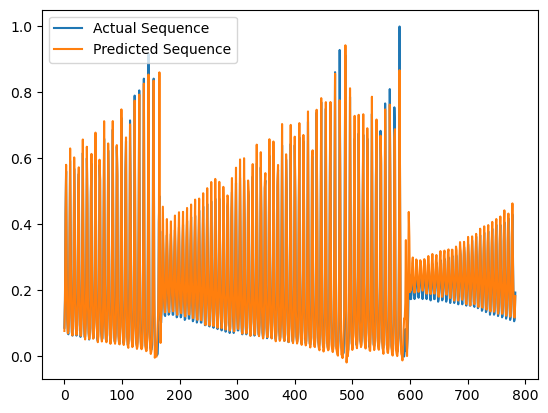

In [147]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Sequence')
plt.plot(predicted, label='Predicted Sequence')
plt.legend()
plt.show()